### Word generator
Network are learned to predict next letter of a word from a list of 20k words.
After that it creates its own word by passing output letter to input.

Here we set up plot inlining options and its size:

In [3]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 12)
from IPython import display

Import modules:

In [4]:
import pynn as nn
import pynnui as nnui
import math
from math import floor
from random import random, shuffle
from copy import copy
import numpy as np
from matplotlib import pyplot as plt
import signal

Load data:

In [15]:
data = open('data/20k.txt').read()
words = []
for word in data.split('\n'):
    words.append(word + '\n')

Char to index and back conversion:

In [26]:
chars = sorted(list(set(data)))
ci = {c:i for i,c in enumerate(chars)}
ic = {i:c for i,c in enumerate(chars)}

size = len(chars)

print(chars)

['\n', "'", '-', '.', '0', '1', '2', '4', '5', '9', 'W', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


To learn our network we use [BPTT](https://en.wikipedia.org/wiki/Backpropagation_through_time) with [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) plus [AdaGrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad). [Softmax](https://en.wikipedia.org/wiki/Softmax_function) loss is used.

In [28]:
def do_batch(net, pos, batch_size):
    loss = 0
    grad = net.newGradient()
       
    for i in range(min(batch_size, len(words) - pos)):
        word = words[pos + i]
        depth = len(word)

        state = net.newState()
        state_stack = []
        vouts_stack = []

        for l in range(depth - 1):
            a = ci[word[l]]
            lin = [0]*size
            lin[a] = 1
            vins = [np.array(lin)]

            # feedforward
            state = copy(state)
            vouts = net.transmit(state, vins)
            state_stack.append(state)
            vouts_stack.append(vouts)

        error = net.newError()

        for l in range(depth - 1):
            a = ci[word[depth - l - 1]]
            lres = [0]*size
            lres[a] = 1
            vres = np.array(lres)
            vin = vouts_stack.pop()[0]
            vout = np.exp(vin)/np.sum(np.exp(vin)) # softmax
            verrs = [vout - vres]
            loss += -np.log(vout[a])

            # backpropagate
            net.backprop(grad, error, state_stack.pop(), verrs)
            
    grad.mul(1/batch_size)
    return (grad, loss/batch_size)

Hyperparameters:

In [38]:
shid = 200
batch_size = 20
rate_factor = 1e-1

Define network structure:

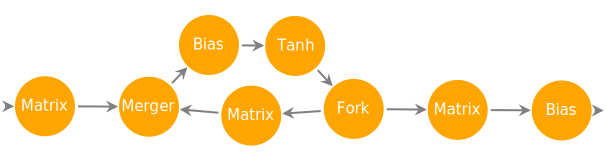

In [39]:
net = nn.Network(1, 1)

net.nodes[0] = nn.MatrixProduct(size, shid) # W_xh
net.nodes[1] = nn.MatrixProduct(shid, shid) # W_hh
net.nodes[2] = nn.Merger(shid, 2)
net.nodes[3] = nn.Bias(shid)
net.nodes[4] = nn.Tanh(shid)
net.nodes[5] = nn.Fork(shid, 2)
net.nodes[6] = nn.MatrixProduct(shid, size) # W_hy
net.nodes[7] = nn.Bias(size)

net.link(nn.Path((-1, 0), ( 0, 0)))
net.link(nn.Path(( 0, 0), ( 2, 0)))
net.link(nn.Path(( 1, 0), ( 2, 1)))

net.link(nn.Path(( 2, 0), ( 3, 0)))
net.link(nn.Path(( 3, 0), ( 4, 0)))
net.link(nn.Path(( 4, 0), ( 5, 0)))

net.link(nn.Path(( 5, 1), ( 1, 0), np.zeros(shid)))
net.link(nn.Path(( 5, 0), ( 6, 0)))
net.link(nn.Path(( 6, 0), ( 7, 0)))
net.link(nn.Path(( 7, 0), (-1, 0)))

rate = nn.RateAdaGrad(net, rate_factor)

display.SVG(data=nnui.Graph(net).svg())

Initialize counters:

In [40]:
b = 0
p = 0
smooth_loss = 0
losses = []
epoch = 0
epochs = []

Main learning loop. You can interrupt it and continue whenever you want.

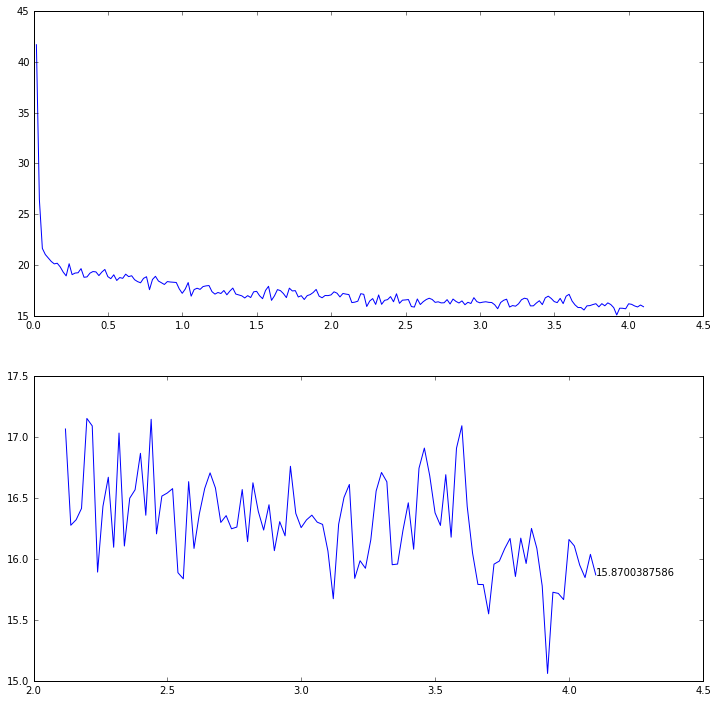

'done'

In [50]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

show_period = 20
while not done:
    if p >= len(words):
        p = 0
        b = 0
        epoch += 1
    if p == 0:
        shuffle(words)
    
    (grad, loss) = do_batch(net, p, batch_size)
    grad.clip(5e0)
    rate.update(grad)
    net.learn(grad, rate)
    
    smooth_loss = 0.9*smooth_loss + 0.1*loss
    
    if (b+1) % show_period == 0:
        smooth_epoch = epoch + p/len(words)
        epochs.append(smooth_epoch)
        losses.append(smooth_loss)

        fig = plt.figure()
        ax = (fig.add_subplot(211), fig.add_subplot(212))
        ax[0].plot(epochs, losses)
        r = max(len(losses) - 100, 0)
        ax[1].plot(epochs[r:],losses[r:])
        ax[1].text(smooth_epoch,smooth_loss,str(smooth_loss))

        display.clear_output(wait=True)

        plt.show()
        
    p += batch_size
    b += 1
    
'done'

Here network generates word for each alphabet letter.

In [55]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

for j in range(len(alphabet)):

    state = net.newState()

    a = ci[alphabet[j]]
    print(alphabet[j], end='')

    for i in range(0x40):
        lin = [0]*size
        lin[a] = 1
        vins = [np.array(lin)]
        vouts = net.transmit(state, vins)
        prob = np.exp(vouts[0])/np.sum(np.exp(vouts[0]))
        a = np.random.choice(range(size), p=prob)
        letter = ic[a]

        if letter == '\n':
            break
        print(letter, end='')
    print()

atdric
bintham
coutininnterioncaly
discre
expeng
flide
guner
hacerot
ipsuobanded
julse
knones
luvs
marm
nevea
oriac
plopenobule
qiaency
retlonk
saedare
triak
un
van
winsiluak
xyliry
ydetims
zeweod
